# CNN 순전파 numpy로만 구현하기

In [141]:
import numpy as np

In [ ]:
from sklearn.datasets import fetch_openml

# MNIST 로드
mnist = fetch_openml("mnist_784", version=1, as_frame=False)

X = mnist.data.astype(np.float32) / 255.0  # (70000, 784)
y = mnist.target.astype(np.int64)

# CNN 입력 형태로 변환
X = X.reshape(-1, 1, 28, 28)

# 100장만 샘플링
np.random.seed(0)
idx = np.random.choice(len(X), 1000, replace=False)
X = X[idx]
y = y[idx]

print("X:", X.shape)  # (100, 1, 28, 28)
print("y:", y.shape)


KeyboardInterrupt: 

### 필요한 하이퍼파라미터 생성

In [143]:
# 필터개수
F = 10
# 스트라이드
s = 1
# 패딩
p = 0
# 필터 사이즈
k = 3

### 변수 생성

In [144]:
m, C, H, W = X.shape

### conv 출력 크기 계산 & 0으로 초기화 & 가중치, 편향(b) 생성

In [145]:
H_out = (H + 2 * p - k) // s + 1
W_out = (W + 2 * p - k) // s + 1

fan_in = C * k**2

Z_1 = np.zeros((m, F, H_out, W_out))
W = np.random.randn(F, C, k, k) * np.sqrt(2 / fan_in)
b = np.zeros(F)


In [146]:
W.shape

(10, 1, 3, 3)

### 합성곱 구현

In [ ]:
# 데이터 개수 만큼 반복
for n in range(m):

    # 필터 개수 만큼 반복
    for f in range(F):

        # 출력 높이 만큼 반복
        for i in range(H_out):

            # 출력 넓이 만큼 반복
            for j in range(W_out):
                h = i * s
                w = j * s

                patch = X[n, :, h : h + k, w: w + k]
                Z_1[n, f, i, j] = np.sum(patch * W[f]) + b[f]

        

In [148]:
Z_1.shape

(100, 10, 26, 26)

### ReLU 함수 구현

In [149]:
A_1 = np.maximum(0, Z_1)

### mav pooling 구현

하이퍼 파라미터

In [150]:
# 스트라이드
s = 2
# 커널 크기
k = 2

출력 크기 계산

In [151]:
H_out_2 = (H_out - k) // s + 1
W_out_2 = (W_out - k) // s + 1

A_2 = np.zeros((m, F, H_out_2, W_out_2))

In [152]:
A_2.shape

(100, 10, 13, 13)

In [153]:
# 데이터 개수 만큼 반복
for n in range(m):

    # 필터 개수 만큼 반복
    for f in range(F):

        # 풀링 출력 높이 
        for i in range(H_out_2):

            # 풀링 출력 넓이만큼 반복
            for j in range(W_out_2):
                h0 = i * s
                w0 = j * s

                window = A_1[n, f, h0 : h0 + k, w0 : w0 + k]
                pooling = np.max(window)
                A_2[n, f, i, j] = pooling

In [154]:
A_2.shape

(100, 10, 13, 13)

In [155]:
A_2 = A_2.reshape(A_2.shape[0], -1)

In [156]:
A_2 = A_2.T

In [157]:
A_2.shape

(1690, 100)

### FC 구현

In [158]:
# 파라미터 초기화

hidden_dim3 = 128
W_3 = np.random.randn(hidden_dim3, A_2.shape[0]) * np.sqrt(2 / A_2.shape[0])
b_3 = np.zeros((hidden_dim3, 1))

# 선형 변환
Z_3 = np.dot(W_3, A_2) + b_3
# ReLU 함수
A_3 = np.maximum(0, Z_3)

# 4 레이어 구현

hidden_dim4 = 10
W_4 = np.random.randn(hidden_dim4, A_3.shape[0]) * np.sqrt(2 / A_3.shape[0])
b_4 = np.zeros((hidden_dim4, 1))

# 선형 변환
Z_4 = np.dot(W_4, A_3) + b_4
# 소프트맥스 함수
Z_shift = Z_4 - np.max(Z_4, axis=0, keepdims=True)
exp_Z = np.exp(Z_shift)
A_4 = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

In [159]:
print("Z_4 shape:", Z_4.shape)
print("A_4 shape:", A_4.shape)
print("sum per sample:", np.sum(A_4, axis=0)[:5])

Z_4 shape: (10, 100)
A_4 shape: (10, 100)
sum per sample: [1. 1. 1. 1. 1.]


In [160]:
def one_hot(y, num_classes):
    y = y.reshape(-1)          # (m,)
    m = y.shape[0]

    Y = np.zeros((num_classes, m))
    Y[y, np.arange(m)] = 1

    return Y

In [161]:
Y = one_hot(y, 10)

In [162]:
eps = 1e-12
loss = -np.sum(Y * np.log(A_4 + eps)) / m

In [163]:
print("A_4 shape:", A_4.shape)
print("Y shape:", Y.shape)
print("loss:", loss)

A_4 shape: (10, 100)
Y shape: (10, 100)
loss: 2.466008987305267


In [164]:
from sklearn.metrics import accuracy_score

# A_4: (10, 100) -> (100,) 로 변환
y_pred = np.argmax(A_4, axis=0)

# accuracy_score(실제값, 예측값)
accuracy = accuracy_score(y, y_pred)

print(f"사이킷런으로 계산한 정확도: {accuracy * 100:.2f}%")

사이킷런으로 계산한 정확도: 5.00%


In [165]:
from sklearn.metrics import confusion_matrix, classification_report

# 어떤 숫자를 특히 못 맞추는지 확인
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

# 정밀도, 재현율 등 종합 보고서
print("\nClassification Report:")
print(classification_report(y, y_pred))

Confusion Matrix:
[[ 1  3  0  0  0  1  1  0  2  6]
 [ 0  2  0  0  8  0  0  0  0  0]
 [ 0  5  1  0  0  0  0  0  0  0]
 [ 0  5  2  0  0  2  0  0  0  0]
 [ 3 10  0  1  0  0  1  0  2  1]
 [ 0  7  0  0  1  0  1  0  0  5]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 2  7  0  0  0  1  0  0  3  0]
 [ 0  3  0  0  2  0  0  0  0  0]
 [ 1  3  0  0  0  0  0  0  0  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.07      0.10        14
           1       0.04      0.20      0.07        10
           2       0.33      0.17      0.22         6
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        14
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00         5
           9       0.08      0.20      0.11         5

    accuracy                   

C:\Users\sungm\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\sungm\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\sungm\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

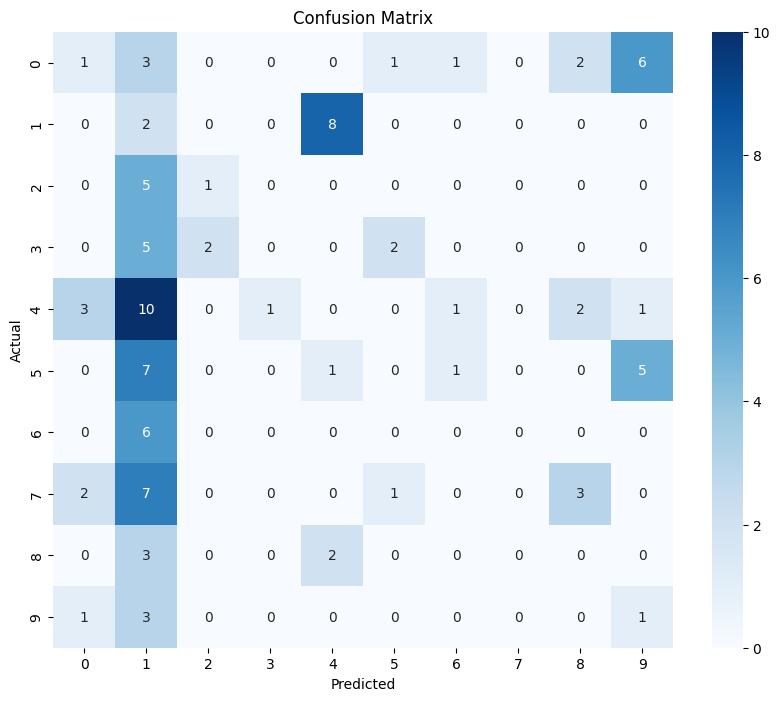

In [166]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 혼동행렬 데이터 생성
# 행(row)은 실제 정답(Actual), 열(column)은 모델의 예측(Predicted)입니다.
cm = confusion_matrix(y, y_pred)

# 2. 시각화 (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()